In [1]:
from prophet import Prophet
from innov8.db_ops import data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
data.main_table[["symbol", "date", "open", "high", "low", "close", "volume"]]

,symbol,date,open,high,low,close,volume
0,A,2022-07-01,117.990277,118.953748,115.914344,118.407448,1119800
1,A,2022-07-05,116.957280,119.867555,115.705760,119.748360,1484900
2,A,2022-07-06,119.986743,121.516368,119.748353,120.364182,1642300
3,A,2022-07-07,120.175461,122.390451,119.807957,122.320923,1221200
4,A,2022-07-08,120.145658,122.380511,120.145658,121.685226,1267300
...,...,...,...,...,...,...,...
125890,ZTS,2023-06-26,167.541546,168.000529,164.188919,167.172348,1729200
125891,ZTS,2023-06-27,168.429595,170.714563,166.783206,170.295486,1452300
125892,ZTS,2023-06-28,170.016090,170.425194,168.379690,168.728928,1686800
125893,ZTS,2023-06-29,168.279908,171.532764,167.830899,171.492844,1429000


In [3]:
# Load the data into a DataFrame
data = data.main_table[["symbol", "date", "open", "high", "low", "close", "volume"]]

# Convert date column to datetime
data["date"] = pd.to_datetime(data["date"])

/tmp/ipykernel_4076/1411144527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["date"] = pd.to_datetime(data["date"])


21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing
21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing
21:08:18 - cmdstanpy - INFO - Chain [1] start processing
21:08:18 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1] done processing
21:08:19 - cmdstanpy - INFO - Chain [1] start processing
21:08:19 - cmdstanpy - INFO - Chain [1]

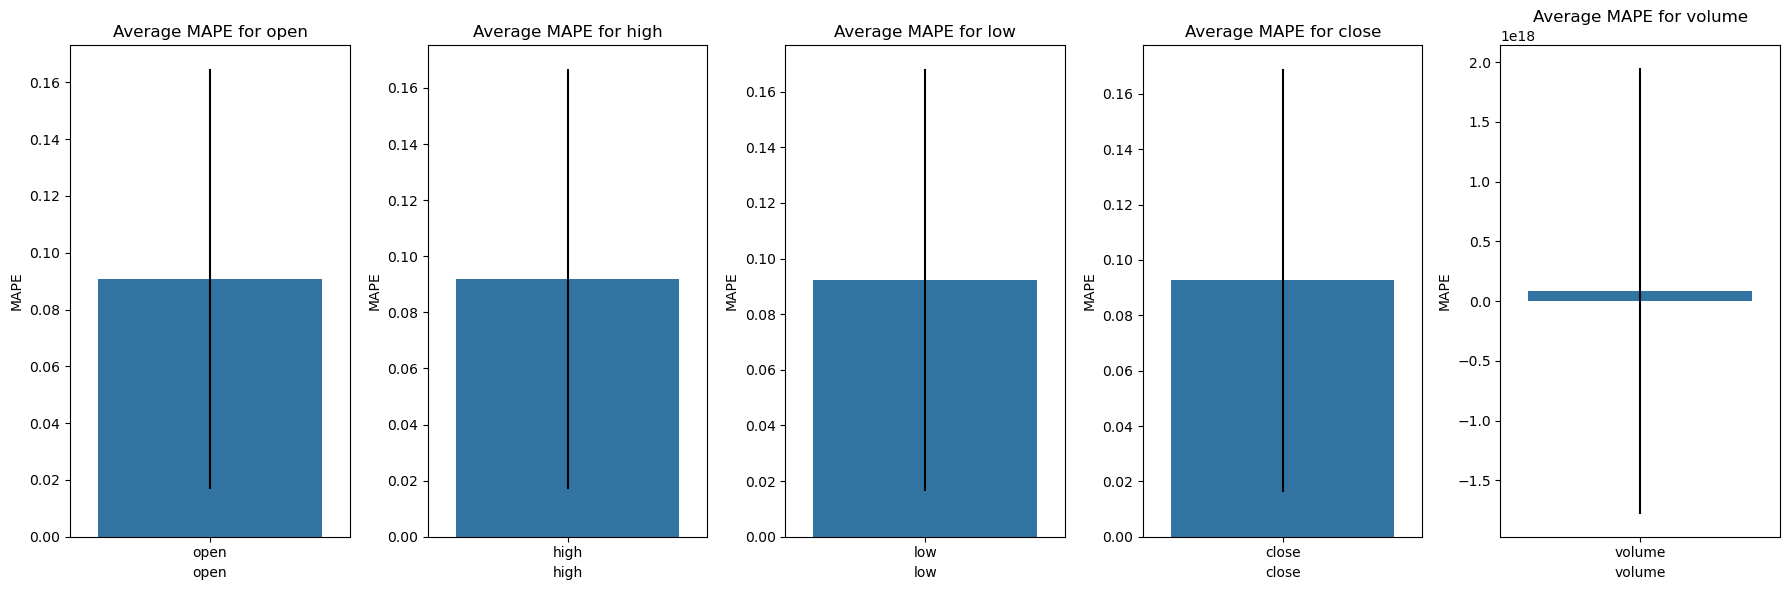

In [4]:
def calculate_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)


# Function to train Prophet model and forecast
def create_prophet_model(df, column, train_size=0.8):
    df_prophet = df[["date", column]].rename(columns={"date": "ds", column: "y"})

    train_index = int(len(df_prophet) * train_size)
    train_df = df_prophet.iloc[:train_index]
    test_df = df_prophet.iloc[train_index:]

    model = Prophet()
    model.fit(train_df)

    future = model.make_future_dataframe(periods=len(test_df), freq="B")
    forecast = model.predict(future)

    predictions = forecast[["ds", "yhat"]].iloc[-len(test_df) :]
    predictions["y_true"] = test_df["y"].values

    mape = calculate_mape(predictions["y_true"], predictions["yhat"])

    return mape


# Store the average MAPE
average_mape = {column: [] for column in ["open", "high", "low", "close", "volume"]}

# Calculate the MAPE for each symbol and column
symbols = data["symbol"].unique()
for symbol in symbols:
    symbol_data = data[data["symbol"] == symbol]
    for column in ["open", "high", "low", "close", "volume"]:
        mape = create_prophet_model(symbol_data, column)
        average_mape[column].append(mape)

# Calculate the average and standard deviation for each column
average_scores = {
    column: {
        "mape_mean": np.mean(average_mape[column]),
        "mape_std": np.std(average_mape[column]),
    }
    for column in ["open", "high", "low", "close", "volume"]
}

# Plotting the MAPE results
fig, ax = plt.subplots(1, len(average_scores), figsize=(18, 6))

for idx, (column, scores) in enumerate(average_scores.items()):
    sns.barplot(
        x=[column],
        y=[scores["mape_mean"]],
        yerr=[scores["mape_std"]],
        capsize=0.1,
        ax=ax[idx],
    )
    ax[idx].set_title(f"Average MAPE for {column}")
    ax[idx].set_ylabel("MAPE")
    ax[idx].set_xlabel(column)

plt.tight_layout()
plt.show()

In [5]:
average_scores

{'open': {'mape_mean': 0.09076955204916755, 'mape_std': 0.0739969566298642},
 'high': {'mape_mean': 0.0918370700499851, 'mape_std': 0.07495712413246992},
 'low': {'mape_mean': 0.09223399164582255, 'mape_std': 0.0759286856780562},
 'close': {'mape_mean': 0.09260666788368, 'mape_std': 0.07642194703081047},
 'volume': {'mape_mean': 8.343833416503646e+16,
  'mape_std': 1.8694656229346977e+18}}